## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt

from scipy import signal 
from IPython.display import display, Math, Latex

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def Calculate_confidence(freqs, fft_mag, bpm_f):
    
    window = 30/60
    fundamental_freq_window = (freqs > bpm_f - window) &\
    (freqs < bpm_f + window)
    return np.sum(fft_mag[fundamental_freq_window])/np.sum(fft_mag)


def Features(ppg, acc, fs):
    # Fourier Transform the ppg signal
    ppg_freqs, ppg_fft = Fourier(ppg, fs)
    
    # Filter data
    ppg_fft[ppg_freqs <= 70/60.0] = 0.0
    ppg_fft[ppg_freqs >= 190/60.0] = 0.0
    
    # Find peaks
    ppg_peaks = signal.find_peaks(ppg_fft, height=2000)[0]
    ppg_peaks_f = ppg_freqs[ppg_peaks]
    
    # Fourier Transform the acc signal
    acc_freqs, acc_fft = Fourier(acc, fs)
    
    # Filter data
    acc_fft[acc_freqs <= 70/60.0] = 0.0
    acc_fft[acc_freqs >= 190/60.0] = 0.0
    
    # Find peaks
    acc_peaks = signal.find_peaks(acc_fft, height=None)[0]
    acc_peaks_f = acc_freqs[acc_peaks]
    
    return {'ppg': (ppg_peaks, ppg_peaks_f, ppg_freqs, ppg_fft), 
            'acc': (acc_peaks, acc_peaks_f, acc_freqs, acc_fft)}


def Estimate_heart_rate(ppg, acc, window_length_s, window_shift_s, fs):
    """ Estimate average heart rate based on window"""
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    est_bpm, confidence = [], []    
    prev_est = 40/60
    for i in range(0, len(ppg) - window_length, window_shift):
        ppg_window = ppg[i:i+window_length]
        acc_window = acc[i:i+window_length]
        window_features = Features(ppg_window, acc, fs)
        ppg_peaks, ppg_peaks_f, ppg_freqs, ppg_fft = window_features['ppg']
        acc_peaks, acc_peaks_f, acc_freqs, acc_fft = window_features['acc']
        ppg_max = ppg_freqs[np.argmax(ppg_fft)]
        acc_max = acc_freqs[np.argmax(acc_fft)]
        k = 1
        while np.abs(acc_max-ppg_max) <= 0.2 and k <=2:
            k+=1
            ppg_max = ppg_freqs[np.argsort(ppg_fft, axis=0)[-k]]
            acc_max = acc_freqs[np.argsort(acc_fft, axis=0)[-k]]
        est_bpm_f = ppg_max
        prev_est = est_bpm_f
        est_bpm.append(est_bpm_f*60)
        confidence.append(Calculate_confidence(ppg_freqs, ppg_fft, est_bpm_f))
    return est_bpm, confidence



def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    bpm = sp.io.loadmat(ref_fl)['BPM0']
    # Compute pulse rate estimates and estimation confidence.
    
    fs = 125
    ppg = BandpassFilter(ppg, fs)
    accx = BandpassFilter(accx, fs)
    accy = BandpassFilter(accy, fs)
    accz = BandpassFilter(accz, fs)
    
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    window_length_s = 8
    window_shift_s = 2 
    
    est_bpm, confidence = Estimate_heart_rate(ppg, acc, window_length_s, window_shift_s, fs)
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors = np.abs(np.diag(np.subtract(bpm, est_bpm))) 
    return errors, confidence


def BandpassFilter(sgnl, fs):
    band = (40.0/60.0, 240.0/60.0)
    b, a = signal.butter(3, band, btype='bandpass', fs=fs)
    return signal.filtfilt(b, a, sgnl)


def Fourier(signal, fs):
    freqs = np.fft.rfftfreq(2*len(signal), 1/fs)
    fft = np.abs(np.fft.rfft(signal, 2*len(signal)))
    return freqs, fft


def plot_fft(signal, freqs, fft, fs):
    plt.subplot(2,1,1)
    ts = np.arange(len(signal)) / fs
    plt.plot(ts, signal)
    plt.subplot(2,1,2)
    plt.plot(freqs, np.abs(fft))
    plt.title("freq domain")
    plt.xlabel("freq")
    plt.tight_layout()

In [2]:
### Load dataset 
data_fls, ref_fls = LoadTroikaDataset()
data_fl, ref_fl = data_fls[0], ref_fls[0]
bpm = sp.io.loadmat(ref_fl)['BPM0']
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
fs = 125

ppg = BandpassFilter(ppg, fs)
accx = BandpassFilter(accx, fs)
accy = BandpassFilter(accy, fs)
accz = BandpassFilter(accz, fs)

In [3]:
accuracy = np.sqrt(accx**2 + accy**2 + accz**2)

In [4]:
ppg_window = ppg[0:8*fs]
acc_window = accuracy[0:8*fs]

ppg_freqs, ppg_fft = Fourier(ppg_window, fs)

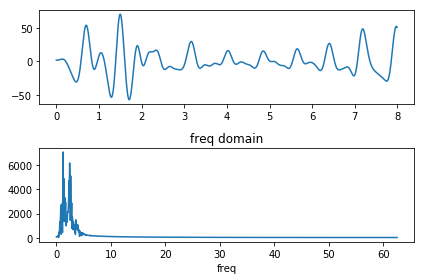

In [5]:
plot_fft(ppg_window, ppg_freqs, ppg_fft, fs)

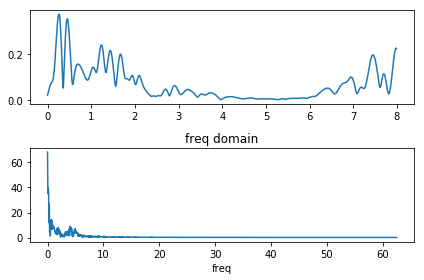

In [6]:
acc_freqs, acc_fft = Fourier(acc_window, fs)
plot_fft(acc_window, acc_freqs, acc_fft, fs)

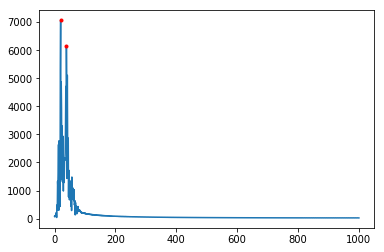

In [7]:
peaks_ppg = sp.signal.find_peaks(ppg_fft, height=2000, distance=10)[0]
plt.plot(ppg_fft)
plt.plot(peaks_ppg, ppg_fft[peaks_ppg], 'r.')

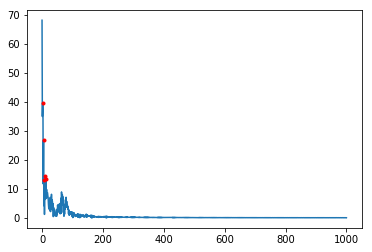

In [8]:
peaks_acc = sp.signal.find_peaks(acc_fft, height=10)[0]
plt.plot(acc_fft)
plt.plot(peaks_acc, acc_fft[peaks_acc], 'r.')

In [9]:
accx_window = accx[0:8*fs]
accy_window = accy[0:8*fs]
accz_window = accz[0:8*fs]

In [10]:
accx_freqs, accx_fft = Fourier(accx_window, fs)
accy_freqs, accy_fft = Fourier(accy_window, fs)
accz_freqs, accz_fft = Fourier(accz_window, fs)

[ 0.6875  0.8125  1.      1.125 ]
[ 1.9375]
[ 0.6875  0.8125  1.      1.25    1.375   1.5625  1.6875  1.8125  2.375
  2.5     2.625   2.75  ]


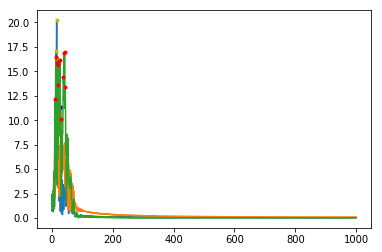

In [11]:
peaks_accx = signal.find_peaks(accx_fft, height=10)[0]
plt.plot(accx_fft)
plt.plot(peaks_accx, accx_fft[peaks_accx], 'y.')
print(accx_freqs[peaks_accx])

peaks_accy = signal.find_peaks(accy_fft, height=10)[0]
plt.plot(accy_fft)
plt.plot(peaks_accy, accy_fft[peaks_accy], 'b.')
print(accy_freqs[peaks_accy])

peaks_accz = signal.find_peaks(accz_fft, height=10)[0]
plt.plot(accz_fft)
plt.plot(peaks_accz, accz_fft[peaks_accz], 'r.')
print(accz_freqs[peaks_accz])

[ 1.9375]


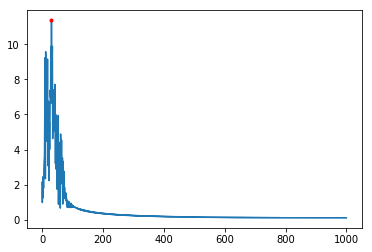

In [12]:
peaks_accy = sp.signal.find_peaks(accy_fft, height=10)[0]
plt.plot(accy_fft)
plt.plot(peaks_accy, accy_fft[peaks_accy], 'r.')
print(accy_freqs[peaks_accy])

[ 0.6875  0.8125  1.      1.25    1.375   1.5625  1.6875  1.8125  2.375
  2.5     2.625   2.75  ]


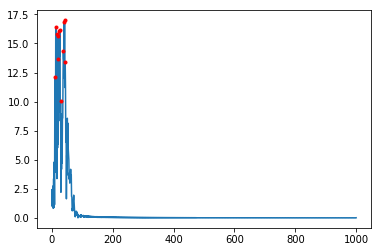

In [13]:
peaks_accz = sp.signal.find_peaks(accz_fft, height=10)[0]
plt.plot(accz_fft)
plt.plot(peaks_accz, accz_fft[peaks_accz], 'r.')
print(accz_freqs[peaks_accz])


In [15]:
Evaluate()

21.125209230238191

### Project Write-up
Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

**Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm.

**Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.

**Algorithhm Description** will include the following:
how the algorithm works
the specific aspects of the physiology that it takes advantage of
a describtion of the algorithm outputs
caveats on algorithm outputs
common failure modes

**Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.
Code description The Evaluate() function will run the code and will load the TROIKA data, estimate the heart rate and then give a confidence interval for each given heart rates.

> **Code description** The Evaluate() function will will load the TROIKA data, estimate the heart rate and then give a confidence interval for each given heart rates.
>
> **Data description** A subset of TROIKA dataset was used to train the model. The framework used for this dataset (as described here:https://ieeexplore.ieee.org/document/6905737) is signal decomposiTion for denoising, sparse signal RecOnstructIon for high-resolution spectrum estimation, and spectral peaK trAcking with verification. The data consists of two-channel PPG signal, three-axis acceleration signals, and one-channel ECG signals. This was recorded simultaneously  from subjects with age from 18 to 35.
Some shortcomings of the dataset are based on the recordings being shorted between rest and running speeds, which may not give a complete and stable picture of the estimations.
>
> **Algorithm description** The algorithm uses Photoplethysmography (PPG) that uses a light source and a photodetector at the surface of skin to measure the volumetric variations of blood circulation and an accelorometer that measures acceleration signals in three axis.
In order to clean and plot the data, it will first go through the bandpass filter to resize the window to 40-240 beats per min. The Accelerometer data are aggregated in the three directions to get a aggregated magnitude. The signal is divided by 8s windows seprarated by 2 seconds. The heart rate is estimated and the movement pulse from the heart beat is filtered out using the accelerometer.
The algorithm may give inaccurate estimations, or fail when arm acceleration is very strong and irregular. 

>
> **Algorithm performance** In order to measure the accuracy of the algorithm, the estimated heart rate is compared to the ECG by using the metric mean absolute error. The mean absolute error `is a measure of errors between paired observations expressing the same phenomenon` [source: https://en.wikipedia.org/wiki/Mean_absolute_error]. The mean absolute error is described by the formula: 
>
>${\displaystyle \mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}}$

> The algorithm outputs the mean absolute error (MAE) at 90% availability. Higher confidence will give a better estimate. 

### Next Steps
You will now go to Test Your Algorithm to apply a unit test to confirm that your algorithm met the success criteria.